## Model 2 Test Accuracy: 0.863968
#### - Sentence is stored as a tuple ( [ tokens ] , [ tags ] )
#### (embedding): Embedding(8140, 256, padding_idx=0)
#### (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
#### (dropout): Dropout(p=0.5, inplace=False)
#### (fc): Linear(in_features=512, out_features=224, bias=True)

In [1]:
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import random_split
from plot_utils import plot, plot_loss_acc, plot_train_val

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def get_txt_file_paths(folder):
    txt_files = []
    for root, _, files in os.walk(folder): 
        for file in files:
            if file.endswith(".txt"):
                txt_files.append(os.path.join(root, file))
    return txt_files

file_paths = get_txt_file_paths("corpus")
print(f"Total .txt files found: {len(file_paths)}")

Total .txt files found: 76


In [4]:
def extract_tokens_and_tags(line):
    tokens = []
    tags = []
    for item in line.strip().split(): 
        if '/' in item: 
            token, tag = item.rsplit('/', 1) 
            tokens.append(token)
            tags.append(tag)
    return tokens, tags

In [5]:
class GaelicPoSDataset(Dataset): 
    def __init__(self, file_paths):
        self.lines = []
        for path in file_paths: 
            with open(path, encoding='utf-8') as file: 
                for line in file:
                    tokens, tags = extract_tokens_and_tags(line)
                    if tokens: 
                        self.lines.append((tokens, tags)) 
    def  __len__(self): 
        return len(self.lines)
    
    def __getitem__(self, index):
        return self.lines[index] 

In [6]:
dataset = GaelicPoSDataset(file_paths) 

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42) 
split_train, split_valid = train_test_split(train_dataset, test_size=0.2, random_state=42) 

In [7]:
print(f"Number of tuples in the training set: {len(split_train)}")
print(f"Number of tuples in the validation set: {len(split_valid)}")
print(f"Number of tuples in the test set: {len(test_dataset)}")
print(f"Total number of tuples/lines in the dataset: {len(split_train) + len(split_valid) + len(test_dataset)}")

Number of tuples in the training set: 6975
Number of tuples in the validation set: 1744
Number of tuples in the test set: 2180
Total number of tuples/lines in the dataset: 10899


In [8]:
def yield_token(dataset):
    for tokens, _ in dataset: 
        yield tokens 

def yield_tag(dataset):
    for _, tags in dataset:
        yield tags 
        
token_vocab = build_vocab_from_iterator(yield_token(dataset), specials=["<pad>", "<unk>"])
token_vocab.set_default_index(token_vocab["<unk>"])

tag_vocab = build_vocab_from_iterator(yield_tag(dataset), specials=["<pad>"])
tag_vocab.set_default_index(tag_vocab["<pad>"])

In [9]:
total_tokens = sum(len(tokens) for tokens, tags in dataset)
print("Total number of tokens in dataset:", total_tokens)
print("Number of unique tokens:", len(token_vocab))
print("Number of unique tags:", len(tag_vocab))

Total number of tokens in dataset: 87040
Number of unique tokens: 8140
Number of unique tags: 224


In [10]:
def collate_batch(batch):
    token_list = []
    tag_list = []

    for tokens, tags in batch:
        token_ids = torch.tensor([token_vocab[token] for token in tokens], dtype=torch.long)
        tag_ids = torch.tensor([tag_vocab[tag] for tag in tags], dtype=torch.long)
        token_list.append(token_ids)
        tag_list.append(tag_ids)
        
    lengths = torch.tensor([len(tokens) for tokens, _ in batch], dtype=torch.long)
    
    token_list = pad_sequence(token_list, batch_first=True, padding_value=token_vocab["<pad>"])
    tag_list = pad_sequence(tag_list, batch_first=True, padding_value=tag_vocab["<pad>"])
    
    return token_list, tag_list, lengths

In [11]:
class PosTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embed_dim=100, hidden_dim=128, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx = 0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout) 
        self.fc = nn.Linear(hidden_dim * 2, tagset_size)
            
    def forward(self, token_ids, lengths):
        embedded = self.embedding(token_ids)
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed)
        lstm_output, _ = pad_packed_sequence(packed_output, batch_first=True)
        dropped_output = self.dropout(lstm_output) 
        tag_scores = self.fc(dropped_output)
        return tag_scores

In [12]:
BATCH_SIZE = 32
train_dataloader = DataLoader(split_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch )
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

In [13]:
model = PosTagger(
    vocab_size = len(token_vocab),
    tagset_size = len(tag_vocab),
    embed_dim=256, 
    hidden_dim=256,
).to(device)

model

PosTagger(
  (embedding): Embedding(8140, 256, padding_idx=0)
  (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=224, bias=True)
)

In [14]:
loss_function = nn.CrossEntropyLoss(ignore_index=tag_vocab["<pad>"])
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    
    with torch.no_grad():
        for tokens, tags, lengths in dataloader:
            tokens, tags, lengths = tokens.to(device), tags.to(device), lengths.to(device)
            
            outputs = model(tokens, lengths) 
            predicted = outputs.argmax(dim=-1)

            mask = tags != tag_vocab["<pad>"]

            total_acc += ((predicted == tags) & mask).sum().item()
            total_count += mask.sum().item()

    return total_acc / total_count if total_count > 0 else 0

In [16]:
epochs = 10
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
best_acc = 0.0

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    
    for tokens, tags, lengths in train_dataloader:
        tokens, tags, lengths = tokens.to(device), tags.to(device), lengths.to(device)
        
        optimizer.zero_grad()
        outputs = model(tokens, lengths)
        loss = loss_function(outputs.view(-1, outputs.shape[-1]), tags.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()   
    train_loss_list.append(total_train_loss)
    
    train_acc = evaluate(train_dataloader)
    train_acc_list.append(train_acc)
    
    val_acc = evaluate(valid_dataloader)
    val_acc_list.append(val_acc)
    
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for tokens, tags, lengths in valid_dataloader:
            tokens, tags, lengths = tokens.to(device), tags.to(device), lengths.to(device)
            outputs = model(tokens, lengths)
            loss = loss_function(outputs.view(-1, outputs.shape[-1]), tags.view(-1))
            total_val_loss += loss.item()
    val_loss_list.append(total_val_loss)
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
    
    print(f"Epoch {epoch + 1}: Train Loss = {total_train_loss:.4f}, Train Accuracy = {train_acc:.4f}, "
          f"Validation Loss = {total_val_loss:4f}, Validation Accuracy = {val_acc:.4f}")

Epoch 1: Train Loss = 451.4514, Train Accuracy = 0.7662, Validation Loss = 61.439713, Validation Accuracy = 0.7334
Epoch 2: Train Loss = 191.7380, Train Accuracy = 0.8565, Validation Loss = 44.504255, Validation Accuracy = 0.7973
Epoch 3: Train Loss = 127.4991, Train Accuracy = 0.9129, Validation Loss = 37.416253, Validation Accuracy = 0.8244
Epoch 4: Train Loss = 88.3549, Train Accuracy = 0.9495, Validation Loss = 34.321894, Validation Accuracy = 0.8401
Epoch 5: Train Loss = 61.8227, Train Accuracy = 0.9714, Validation Loss = 33.137707, Validation Accuracy = 0.8471
Epoch 6: Train Loss = 41.3005, Train Accuracy = 0.9869, Validation Loss = 31.968488, Validation Accuracy = 0.8546
Epoch 7: Train Loss = 28.2742, Train Accuracy = 0.9933, Validation Loss = 32.096605, Validation Accuracy = 0.8571
Epoch 8: Train Loss = 19.3987, Train Accuracy = 0.9969, Validation Loss = 32.278750, Validation Accuracy = 0.8582
Epoch 9: Train Loss = 13.7342, Train Accuracy = 0.9981, Validation Loss = 32.607054, 

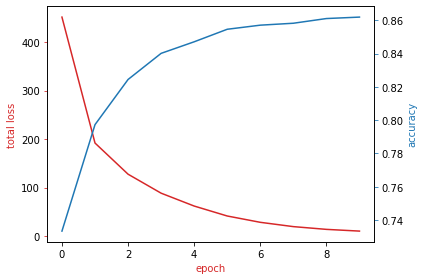

In [17]:
plot(train_loss_list, val_acc_list)

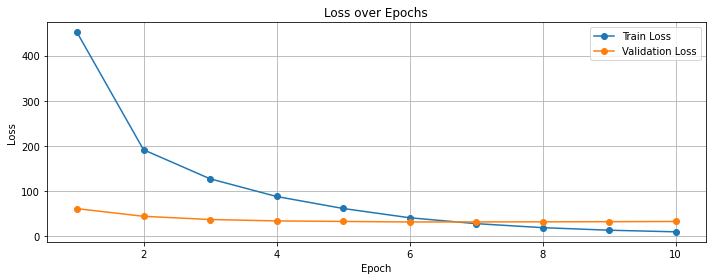

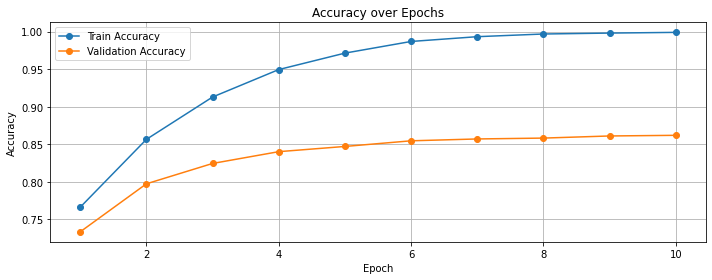

In [18]:
plot_train_val(epochs, train_loss_list, val_loss_list, train_acc_list, val_acc_list)

### Model Accuracy:

In [19]:
model.load_state_dict(torch.load("best_model.pt"))
test_acc = evaluate(test_dataloader)
print("Test Accuracy:", test_acc)

Test Accuracy: 0.8639685216413716


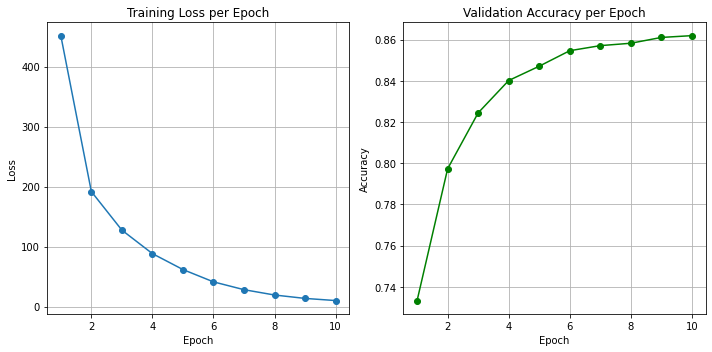

In [20]:
plot_loss_acc(epochs, train_loss_list, val_acc_list)